# Sea ice drift: identifying dynamic contributions to ice motion from wind and ocean

In this project, we are interested in identifying changes in the dynamics and thermodynamics of sea ice as ice drifts through the complex environment of the Fram Strait. Our previous work has demonstrated differences in sea ice dynamics between different ocean regions that are likely due to ocean currents. In particular, we detected differences in the frequency domain that were concentrated at tidal frequencies. In this next stage, we want to understand changes in the sea ice energy balance due to changes in the ocean properties. This task involves understanding and using data from a variety of sources. This notebook demonstrates a method for identifying the contribution of wind to the sea ice drift.

Sea ice drift is results from the combination of atmosphere, ocean, and internal ice stresses. Other important forces include the effects of the Coriolis force and the sea surface slope. One way to examine the influence of the wind is to consider a simple linear model for ice drift, which in some regions can explain the majority of variability in ice velocity:

$$ U_{ice} = \alpha \exp(-i\theta) U_{wind} + \epsilon $$

The parameters $\alpha$ and $\theta$ are referred to as the *transfer coefficient* and the *(atmospheric) turning angle*. We can estimate these values empirically; for now we will assume some standard values for these coefficients.

$$ \alpha = 1.5\%, \theta = 20^\circ $$

The residual, $\epsilon$, is especially important. This is the portion of the motion that is not explained by the wind. In reality, even in the total absence of internal ice stresses (free drift), $\alpha$ and $\theta$ evolve as the ocean and atmosphere boundary layers develop. So we expect some variability in $\epsilon$ in all cases. If $\alpha$ and $\theta$ are correct, and the residual is a large fraction of the net velocity, then there are a few main possibilities: (1) the ice is not in free drift and is either prevented from motion from other ice getting in the way or the ice is getting pushed remotely, for example by a strong wind some distance away (2) the ocean current is contributing a large portion of the velocity. In that case, a better model of free drift would be

$$ U_{ice} = \alpha \exp(-i\theta) U_{wind} + U_{ocean} + \varepsilon $$

with the assumption that the ice is in equilibrium with the upper ocean current $U_{ocean}$. In some cases (i.e. under the assumption that $\varepsilon$ is small), we may be able to statistically estimate $U_{ocean}$ from the residual $\epsilon$.

In this notebook, I show how to estimate the ice motion from a wind field using the data in `data/hourly_merged_buoy_data`.

In [1]:
import cartopy.crs as ccrs
import os
import numpy as np
import pandas as pd
import proplot as pplt
import pyproj
import xarray as xr

In [2]:
files = os.listdir('../data/hourly_merged_buoy_data/')
buoy_data = {f.split('.')[0]: pd.read_csv('../data/hourly_merged_buoy_data/' + f, index_col='datetime', parse_dates=True)
             for f in files if f[0] != '.'}

ds_depth = xr.open_dataset('../data/interpolated_depth.nc')


In [5]:
# This step converts latitude and longitude into polar stereographic coordinates,
# which lets us approximate positions in a horizontal plane.

projIn = 'epsg:4326' # WGS 84 Ellipsoid
projOut = 'epsg:3413' # NSIDC Polar Stereographic
transform_to_xy = pyproj.Transformer.from_crs(projIn, projOut, always_xy=True)

for buoy in buoy_data:
    buoy_df = buoy_data[buoy]

    lon = buoy_data[buoy].longitude.values
    lat = buoy_data[buoy].latitude.values

    xvar = 'x_stere'
    yvar = 'y_stere'

    x, y = transform_to_xy.transform(lon, lat)
    buoy_data[buoy][xvar] = x
    buoy_data[buoy][yvar] = y

In [6]:
# Apply the linear wind drift model
# Need to have theta in radians and alpha as a fraction
theta = np.deg2rad(20)
alpha = 0.015

for buoy in buoy_data:
    
    # Converting velocity into a 1D complex number shortens the number of steps
    Uwind = buoy_data[buoy]['u_wind'] + 1j*buoy_data[buoy]['v_wind']
    Uice = alpha*np.exp(-1j*theta)*Uwind

    # Convert back into real numbers
    buoy_data[buoy]['u_ice_est'] = np.real(Uice)
    buoy_data[buoy]['v_ice_est'] = np.imag(Uice)

    # residual
    buoy_data[buoy]['u_error'] =  buoy_data[buoy]['u'] - buoy_data[buoy]['u_ice_est']
    buoy_data[buoy]['v_error'] =  buoy_data[buoy]['v'] - buoy_data[buoy]['v_ice_est']


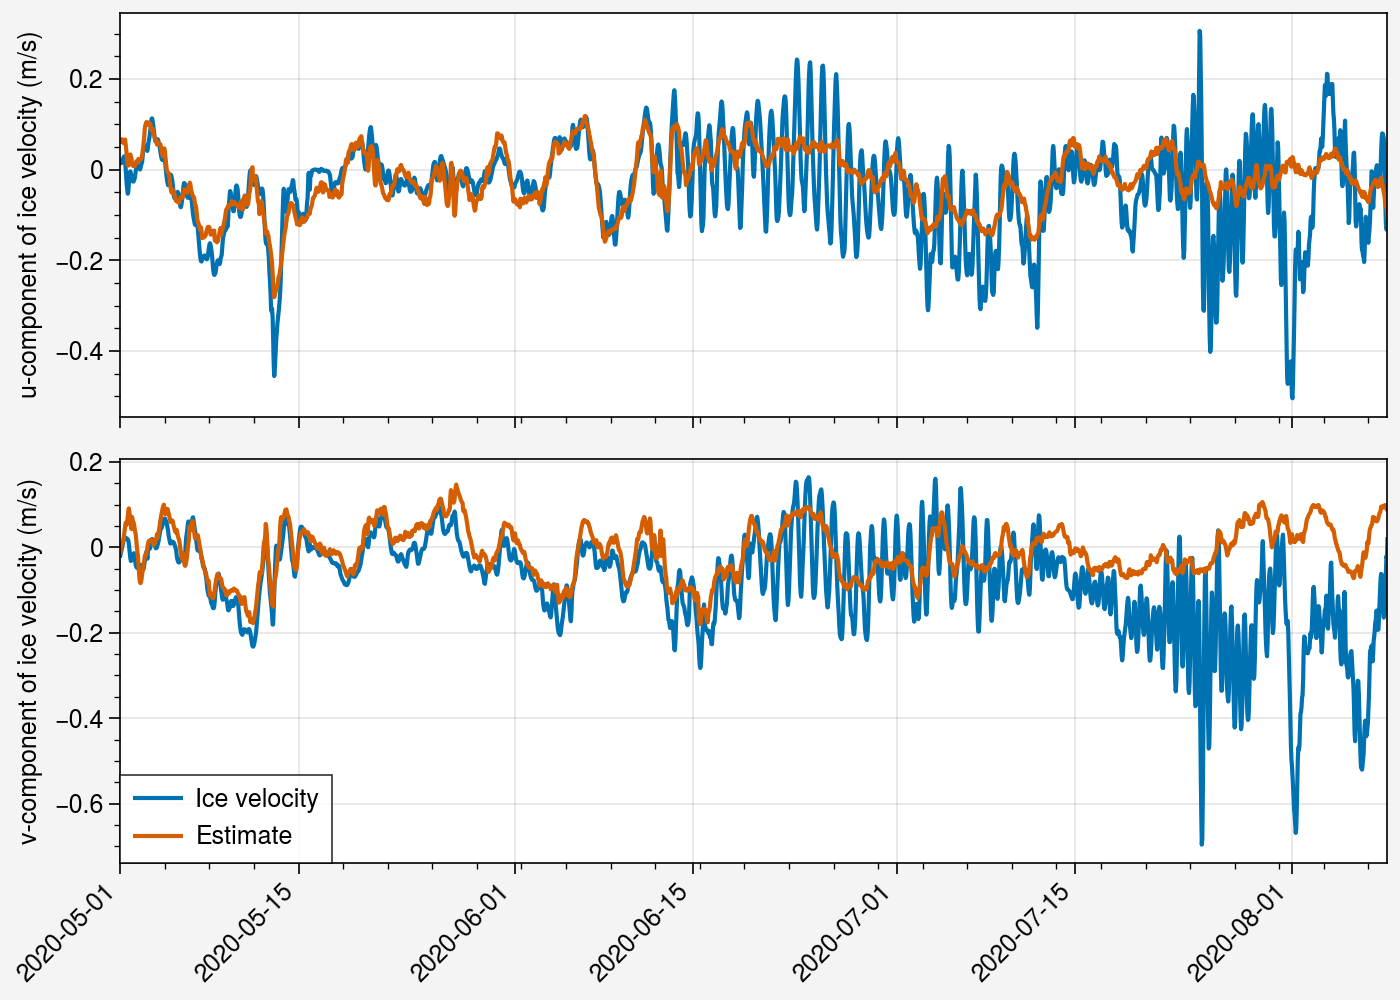

In [39]:
buoy = '2019T66'
fig, axs = pplt.subplots(width=7, height=5, nrows=2, spany=False)
for ax, dir in zip(axs, ['u', 'v']):
    ax.plot(buoy_data[buoy][dir], label='Ice velocity')
    ax.plot(buoy_data[buoy][dir + '_ice_est'], label='Estimate')
    ax.format(ylabel=dir+'-component of ice velocity (m/s)', xlabel='', xrotation=45)
ax.legend(loc='ll', ncols=1)